In [1062]:
pip install --upgrade mxnet~=1.7 gluonts

In [1063]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [1064]:
# gluon datasets
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [1065]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [1066]:
pip install mxnet

In [1067]:
dataset_nasa = pd.read_csv('DOE-551-600-10DU-01_1.csv')

In [1068]:
dataset_nasa


,index,Test_Time,Step_Time(s),Cycle_Index,Step_Index,Voltage,Test_Time(s),Step_Time(s).1,Cycle_Index.1,Step_Index.1,Current,Test_Time(s).1,Step_Time(s).2,Cycle_Index.2,Step_Index.2,Charge_Capacity,Test_Time(s).2,Step_Time(s).3,Cycle_Index.3,Step_Index.3,Discharge_Capacity
0,0,120.001100,120.0010,1,1,3.575560,120.001100,120.0010,1,1,0.000000,120.001100,120.0010,1,1,0.000000,120.001100,120.0010,1,1,0.000000
1,1,240.004000,240.0039,1,1,3.575512,240.004000,240.0039,1,1,0.000000,240.004000,240.0039,1,1,0.000000,240.004000,240.0039,1,1,0.000000
2,2,360.002300,360.0022,1,1,3.577263,360.002300,360.0022,1,1,0.000000,360.002300,360.0022,1,1,0.000000,360.002300,360.0022,1,1,0.000000
3,3,480.004900,480.0048,1,1,3.578959,480.004900,480.0048,1,1,0.000000,480.004900,480.0048,1,1,0.000000,480.004900,480.0048,1,1,0.000000
4,4,600.005800,600.0057,1,1,3.579659,600.005800,600.0057,1,1,0.000000,600.005800,600.0057,1,1,0.000000,600.005800,600.0057,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,3976,461127.552312,120.0001,50,6,3.611401,461127.552312,120.0001,50,6,0.000000,461127.552312,120.0001,50,6,2.450970,461127.552312,120.0001,50,6,2.449697
3977,3977,461247.553112,240.0009,50,6,3.644613,461247.553112,240.0009,50,6,0.000000,461247.553112,240.0009,50,6,2.450970,461247.553112,240.0009,50,6,2.449697
3978,3978,461307.554012,300.0018,50,6,3.652942,461307.554012,300.0018,50,6,0.000000,461307.554012,300.0018,50,6,2.450970,461307.554012,300.0018,50,6,2.449697
3979,3979,461427.643156,120.0016,51,8,4.190305,461427.643156,120.0016,51,8,3.260095,461427.643156,120.0016,51,8,0.108668,461427.643156,120.0016,51,8,0.000000


In [1069]:
df = pd.DataFrame(dataset_nasa)
cols = [0,15]
df = df[df.columns[cols]]

In [1070]:
df

,index,Charge_Capacity
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
...,...,...
3976,3976,2.450970
3977,3977,2.450970
3978,3978,2.450970
3979,3979,0.108668


In [1071]:
df1 = df.to_numpy()

In [1072]:
train_size = int(len(df1)*0.8)
test_size = len(df1) - train_size
train = df1[1:train_size,:]
test = df1[train_size:len(df1)]

In [1073]:
train_size

3184

In [1074]:
train_set = pd.DataFrame(train)

In [1075]:
train_set

,0,1
0,1.0,0.000000
1,2.0,0.000000
2,3.0,0.000000
3,4.0,0.000000
4,5.0,0.000000
...,...,...
3178,3179.0,2.455641
3179,3180.0,2.455641
3180,3181.0,2.455641
3181,3182.0,2.455641


In [1076]:
test_set = pd.DataFrame(test)

In [1077]:
test_set

,0,1
0,3184.0,2.455641
1,3185.0,2.455641
2,3186.0,2.455641
3,3187.0,2.455641
4,3188.0,2.455641
...,...,...
792,3976.0,2.450970
793,3977.0,2.450970
794,3978.0,2.450970
795,3979.0,0.108668


In [1078]:
df.columns

Index(['index', 'Charge_Capacity'], dtype='object')

In [1079]:
df_input = df[['index','Charge_Capacity']]

In [1080]:
df_input = df_input.set_index('index')

In [1081]:
train_time = 949
prediction_length = 949
freq = "2min"

In [1082]:
from gluonts.dataset.common import ListDataset
train_data = ListDataset(
    [{"start": df_input.index[0], "target": df_input.Charge_Capacity[:train_time] }],
    freq = "2min"
)

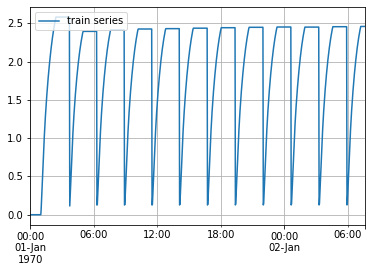

In [1083]:
entry = next(iter(train_data))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.savefig("fig1.pdf",bbox_inches="tight")
plt.show()

In [1084]:
test_data = ListDataset(
    [{"start": df_input.index[0], "target": df_input.Charge_Capacity[:]}],
    freq = "2min"
)

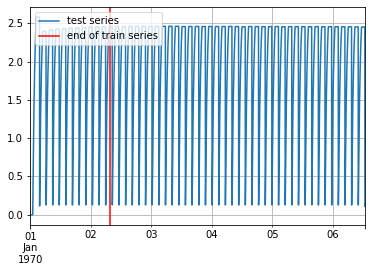

In [1085]:
entry = next(iter(test_data))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.savefig("fig2.pdf",bbox_inches="tight")
plt.show()

In [1086]:
print(f"Length of forecasting window in test dataset:{len(test_series)-len(train_series)}")
print(f"Frequency of the time series:{freq}")

Length of forecasting window in test dataset:3032
Frequency of the time series:2min


In [1087]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer

In [1088]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=250,
    context_length=50,
    freq="2min",
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

In [1089]:
predictor = estimator.train(train_data)

100%|██████████| 100/100 [00:01<00:00, 75.61it/s, epoch=5/5, avg_epoch_loss=-.0797]


In [1090]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [1091]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,  # number of sample paths we want for evaluation 100
)

In [1092]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [1093]:
# first entry of the time series list
ts_entry = tss[0]

In [1094]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([0., 0., 0., 0., 0.], dtype=float32)

In [1095]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_data))

In [1096]:
# first 5 values
dataset_test_entry['target'][:5]

array([0., 0., 0., 0., 0.], dtype=float32)

In [1097]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [1098]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 500
Dimension of samples: (500, 250)
Start date of the forecast window: 1970-01-06 04:22:00
Frequency of the time series: 2min


In [1099]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [2.586221  2.5264056 2.5761518 2.6368139 2.5215886 2.5515811 2.565535
 2.5894141 2.6102262 2.6840262 2.6542342 2.623831  2.651104  2.6656573
 2.654872  2.5007288 1.8036047 1.6343932 1.5808729 1.3029075 1.2696551
 1.4131658 1.5219231 1.4155419 1.4323236 1.4620389 1.5570887 1.5785923
 1.6320968 1.6780978 1.6608951 1.6761935 1.8663727 1.9792807 1.8745011
 1.9917864 2.1725159 2.0053873 2.1673791 2.1783717 2.2361054 2.2479646
 2.3060524 2.3023164 2.312674  2.37398   2.383433  2.462077  2.4646013
 2.5056741 2.4393728 2.452048  2.4730825 2.5788016 2.4234893 2.486988
 2.5055184 2.5053058 2.3745265 2.4648957 2.4707098 2.4518657 2.4960997
 2.5217848 2.521597  2.4480436 2.4930444 2.471131  2.4604049 2.516079
 2.4193263 2.4363215 2.405578  2.4088905 2.4044704 2.3981972 2.4231994
 2.4411514 2.460349  2.52326   2.51957   2.5191653 2.504115  2.5555234
 2.5450735 2.561768  2.615024  2.6032193 2.613888  2.5543654 2.6015844
 2.6342998 2.583423  2.5772276 2.4569833 1.6974496 1

In [1102]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 500
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.ylim(0,3)
    plt.legend(legend, loc="upper left")
    plt.savefig("fig3.pdf",bbox_inches="tight")
    plt.show()

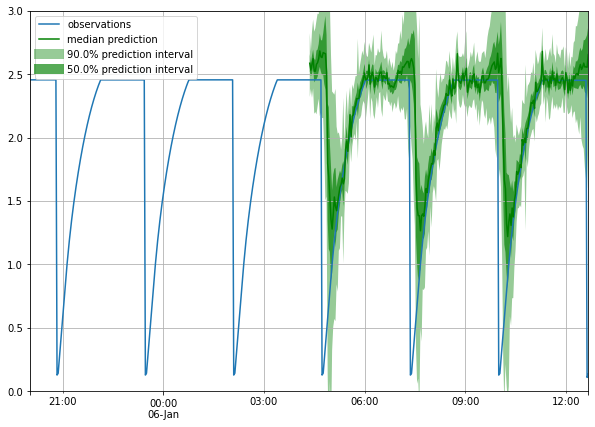

In [1103]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [1104]:
from gluonts.evaluation import Evaluator


In [1105]:
evaluator = Evaluator(quantiles=[0.5,0.1,0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 25.48it/s]


In [1106]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.400576416015625,
    "abs_error": 63.654727935791016,
    "abs_target_sum": 502.94873046875,
    "abs_target_mean": 2.011794921875,
    "seasonal_error": 0.4671777214017353,
    "MASE": 0.5450150982782253,
    "MAPE": 0.9306527709960938,
    "sMAPE": 0.17624380493164063,
    "MSIS": 8.672439568573948,
    "QuantileLoss[0.5]": 63.654727935791016,
    "Coverage[0.5]": 0.788,
    "QuantileLoss[0.1]": 60.973002314567566,
    "Coverage[0.1]": 0.092,
    "QuantileLoss[0.9]": 25.75133836269378,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.6329110648547907,
    "NRMSE": 0.31460019009537776,
    "ND": 0.12656305519742456,
    "wQuantileLoss[0.5]": 0.12656305519742456,
    "wQuantileLoss[0.1]": 0.12123104925176073,
    "wQuantileLoss[0.9]": 0.051200722464680326,
    "mean_absolute_QuantileLoss": 50.12635620435079,
    "mean_wQuantileLoss": 0.09966494230462186,
    "MAE_Coverage": 0.132,
    "OWA": NaN
}


In [1107]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.400576,63.654728,502.94873,2.011795,0.467178,0.545015,0.930653,0.176244,8.67244,63.654728,0.788,60.973002,0.092,25.751338,1.0


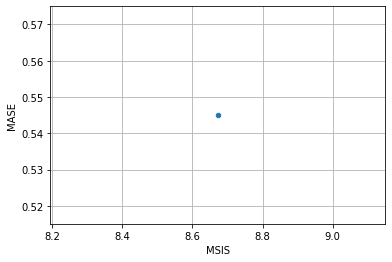

In [1108]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.savefig("fig4.pdf",bbox_inches="tight")
plt.show()

In [1109]:
# own forecast model

In [1110]:
class MyNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=820, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=820, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='relu'))


class MyTrainNetwork(MyNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

In [1111]:
def plot_prob_forecasts_2(ts_entry, forecast_entry):
    plot_length = 500
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.ylim(0,3)
    plt.legend(legend, loc="upper left")
    plt.savefig("fig5.pdf",bbox_inches="tight")
    plt.show()

In [1112]:
from functools import partial
from mxnet.gluon import HybridBlock
from gluonts.core.component import validated
from gluonts.dataset.loader import TrainDataLoader
from gluonts.model.predictor import Predictor
from gluonts.mx.batchify import as_in_context, batchify
from gluonts.mx.model.estimator import GluonEstimator
from gluonts.mx.model.predictor import RepresentableBlockPredictor
from gluonts.mx.trainer import Trainer
from gluonts.mx.util import copy_parameters, get_hybrid_forward_input_names
from gluonts.transform import (
    ExpectedNumInstanceSampler,
    Transformation,
    InstanceSplitter,
    TestSplitSampler,
    SelectFields,
    Chain
)

In [1113]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        num_cells: int,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.num_cells = num_cells

    def create_transformation(self):
        return Chain([])

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length
            ),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )
        input_names = get_hybrid_forward_input_names(MyTrainNetwork)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            decode_fn=partial(as_in_context, ctx=self.trainer.ctx),
            **kwargs,
        )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length,
            num_cells = self.num_cells
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length,
            num_cells=self.num_cells
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [1114]:

# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': 1901,
    'prediction_length': 100,
    'freq': '2min',
    'start': [
        pd.Timestamp("01-01-2019", freq='2min')
        for _ in range(100)
    ]
}

In [1115]:
estimator = MyEstimator(
    prediction_length=250,     #custom_ds_metadata['prediction_length'],
    context_length = custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    num_cells=40,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-2,
        hybridize=False,
        num_batches_per_epoch=2000
    )
)

In [1116]:
from gluonts.dataset.field_names import FieldName
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

In [1117]:
predictor = estimator.train(train_data)

100%|██████████| 2000/2000 [02:43<00:00, 12.23it/s, epoch=5/5, avg_epoch_loss=0.109]


In [1118]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [1119]:
forecasts = list(forecast_it)
tss = list(ts_it)

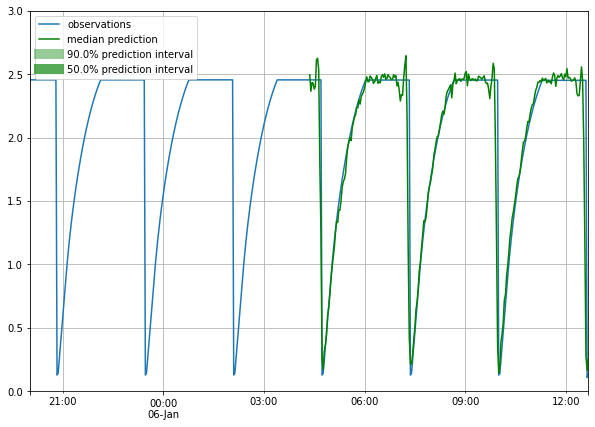

In [1120]:
plot_prob_forecasts_2(tss[0], forecasts[0])

In [1121]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 31.11it/s]


In [1122]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.0854375,
    "abs_error": 23.531204223632812,
    "abs_target_sum": 502.94873046875,
    "abs_target_mean": 2.011794921875,
    "seasonal_error": 0.4671777214017353,
    "MASE": 0.2014753970119039,
    "MAPE": 0.06663111877441406,
    "sMAPE": 0.07199911499023437,
    "MSIS": 8.059016925648534,
    "QuantileLoss[0.1]": 15.302606345713137,
    "Coverage[0.1]": 0.584,
    "QuantileLoss[0.5]": 23.531204886734486,
    "Coverage[0.5]": 0.584,
    "QuantileLoss[0.9]": 31.759803427755834,
    "Coverage[0.9]": 0.584,
    "RMSE": 0.29229693806128043,
    "NRMSE": 0.14529161739252164,
    "ND": 0.04678648696796917,
    "wQuantileLoss[0.1]": 0.030425777855033163,
    "wQuantileLoss[0.5]": 0.04678648828639714,
    "wQuantileLoss[0.9]": 0.06314719871776112,
    "mean_absolute_QuantileLoss": 23.531204886734486,
    "mean_wQuantileLoss": 0.04678648828639714,
    "MAE_Coverage": 0.2946666666666667,
    "OWA": NaN
}


In [1123]:
item_metrics.head(10)

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.085437,23.531204,502.94873,2.011795,0.467178,0.201475,0.066631,0.071999,8.059017,15.302606,0.584,23.531205,0.584,31.759803,0.584


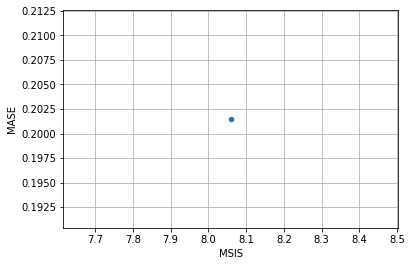

In [1124]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.savefig("fig6.pdf",bbox_inches="tight")
plt.show()